In [1]:
import numpy as np
import pandas as pd

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [5]:
! pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4835 sha256=17a63b33c2a72b40b3a182933f982c8b2a17cc3b4ddce2728d0708a03c4a4c57
  Stored in directory: C:\Users\gladi\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built termcolor
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0


## Load ASL dataset

In [8]:
train_df = pd.read_csv("C:\\Users\\gladi\\Documents\\CNN\\American sign\\sign_mnist_train.csv")
test_df = pd.read_csv("C:\\Users\\gladi\\Documents\\CNN\\American sign\\sign_mnist_test.csv")

In [9]:
y = test_df['label']

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Data Visualization and Preprocessing

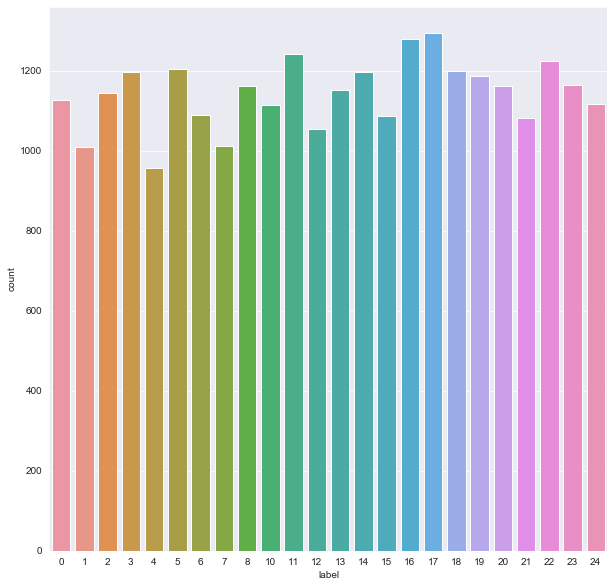

In [12]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [13]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [14]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [15]:
x_train = train_df.values
x_test = test_df.values

In [17]:
# We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshape data from 1d to 3d
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

## Review the first 10 images

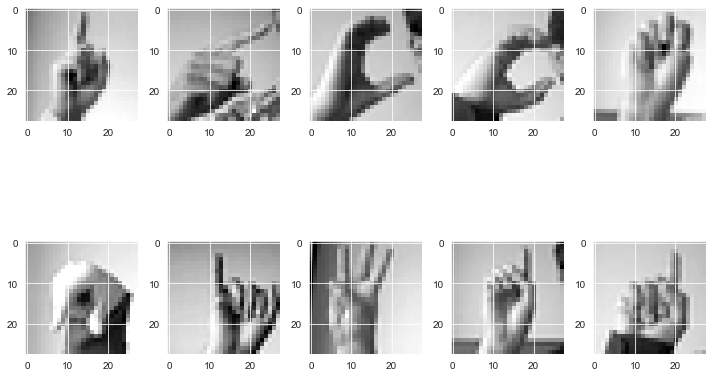

In [19]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [20]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE
A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

A convolution does this by multiplying two matrices and yielding a third, smaller matrix.
The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.
In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure

## Train the model

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [22]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

In [23]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 92s 427ms/step - loss: 1.2252 - accuracy: 0.6124 - val_loss: 3.2416 - val_accuracy: 0.0602
Epoch 2/20
215/215 [==============================] - 91s 425ms/step - loss: 0.3124 - accuracy: 0.8955 - val_loss: 3.3707 - val_accuracy: 0.0959
Epoch 3/20
215/215 [==============================] - 90s 420ms/step - loss: 0.1516 - accuracy: 0.9496 - val_loss: 3.7073 - val_accuracy: 0.1672
Epoch 4/20
215/215 [==============================] - 91s 423ms/step - loss: 0.1026 - accuracy: 0.9662 - val_loss: 10.1493 - val_accuracy: 0.1118
Epoch 5/20
215/215 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9763
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 92s 429ms/step - loss: 0.0730 - accuracy: 0.9763 - val_loss: 15.1507 - val_accuracy: 0.1299
Epoch 6/20
215/215 [==============================] - 91s 425ms/step - loss: 0.0438 - accuracy: 0.9870 - val

In [24]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 14ms/step - loss: 0.6030 - accuracy: 0.8204
Accuracy of the model is -  82.04126954078674 %


## Analysis after Model Training

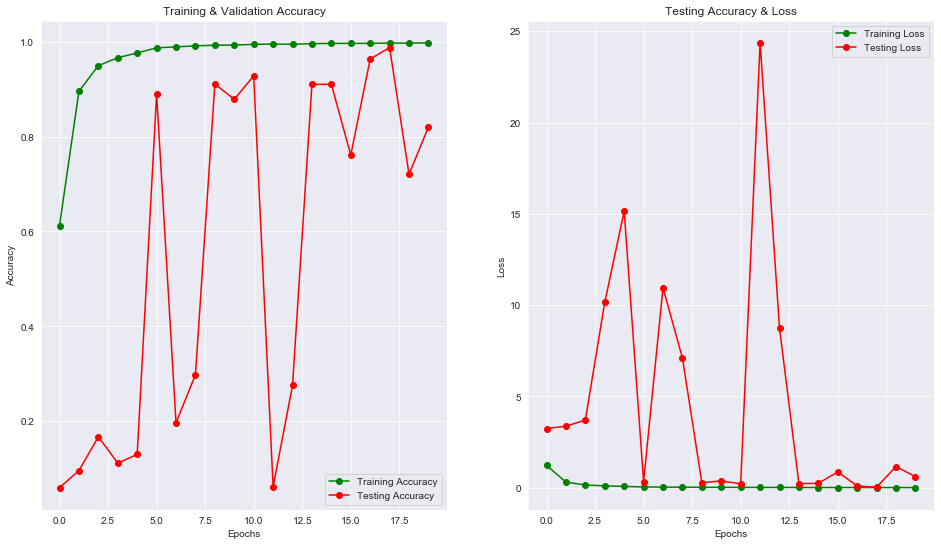

In [25]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [26]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]  

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([ 6,  5, 20,  0,  3], dtype=int64)

In [27]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.80      1.00      0.89       331
     Class 1       0.71      1.00      0.83       432
     Class 2       0.69      1.00      0.81       310
     Class 3       1.00      0.66      0.80       245
     Class 4       0.87      0.98      0.92       498
     Class 5       0.50      1.00      0.66       247
     Class 6       0.99      0.87      0.92       348
     Class 7       0.88      1.00      0.93       436
     Class 8       0.94      0.97      0.96       288
    Class 10       1.00      0.58      0.74       331
    Class 11       0.81      1.00      0.90       209
    Class 12       0.96      0.91      0.93       394
    Class 13       1.00      0.55      0.71       291
    Class 14       1.00      0.61      0.76       246
    Class 15       1.00      0.83      0.91       347
    Class 16       0.95      1.00      0.97       164
    Class 17       1.00      0.44      0.62       144
    Class 18       0.95    

In [28]:
cm = confusion_matrix(y,predictions)

In [29]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

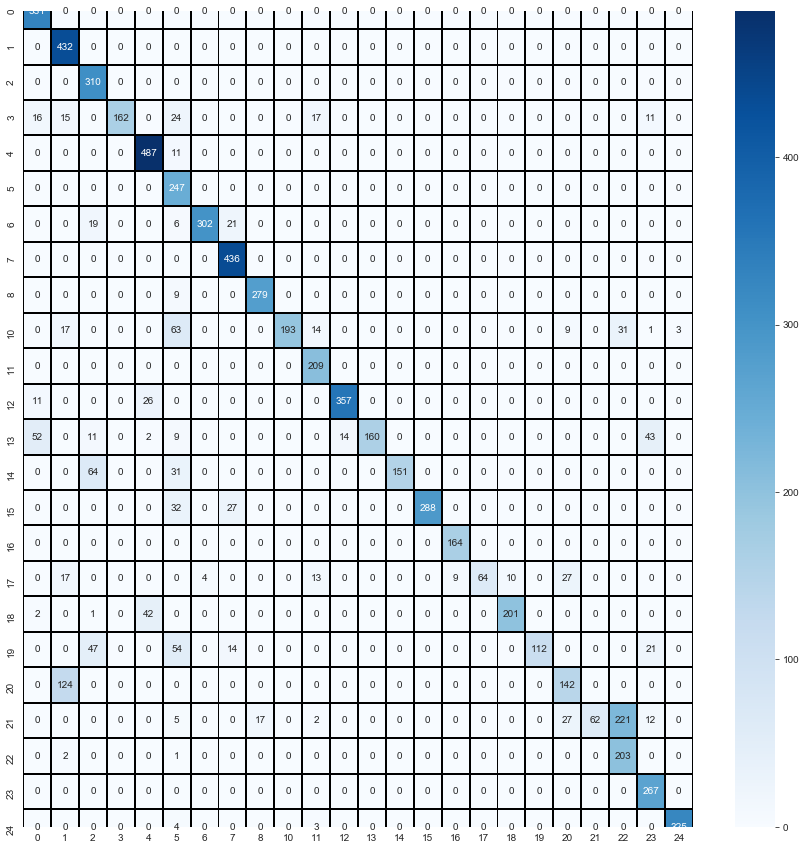

In [30]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [31]:
correct = np.nonzero(predictions == y)[0]

C:\Users\gladi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


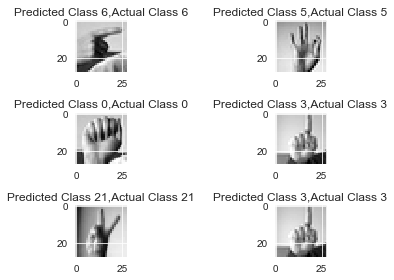

In [32]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1